# Example - FRET histogram fitting

*This notebook is part of smFRET burst analysis software [FRETBursts](http://opensmfs.github.io/FRETBursts/).*

> In this notebook shows how to fit a FRET histogram.
> For a complete tutorial on burst analysis see 
> [FRETBursts - us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5+5.g5243bc2).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook(apionly=True)
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.7


In [3]:
# Tweak here matplotlib style
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

# Get and process data

In [4]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'
download_file(url, save_dir='./data')
full_fname = "./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

d = loader.photon_hdf5(full_fname)
loader.alex_apply_period(d)
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=(800, 4000, 1500, 1000, 3000))
d.burst_search(L=10, m=10, F=6)
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


# Total photons (after ALEX selection):     2,259,522
#  D  photons in D+A excitation periods:      721,537
#  A  photons in D+A excitation periods:    1,537,985
# D+A photons in  D  excitation period:     1,434,842
# D+A photons in  A  excitation period:       824,680

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   [DONE Counting D/A]


# Fitting the FRET histogram



We start defining the model. Here we choose a 3-Gaussian model:

In [5]:
model = mfit.factory_three_gaussians()
model.print_param_hints()

Name             Value      Min      Max     Vary    Expr    
p1_amplitude         1     0.01      inf     True    
p1_center            0        0        1     True    
p1_fwhm            nan     -inf      inf     True    2.3548200*p1_sigma
p1_height          nan     -inf      inf     True    0.3989423*p1_amplitude/max(1.e-15, p1_sigma)
p1_sigma          0.05     0.02      0.2     True    
p2_amplitude         1     0.01      inf     True    
p2_center          0.5        0        1     True    
p2_fwhm            nan     -inf      inf     True    2.3548200*p2_sigma
p2_height          nan     -inf      inf     True    0.3989423*p2_amplitude/max(1.e-15, p2_sigma)
p2_sigma          0.05     0.02      0.2     True    
p3_amplitude         1     0.01      inf     True    
p3_center            1        0        1     True    
p3_fwhm            nan     -inf      inf     True    2.3548200*p3_sigma
p3_height          nan     -inf      inf     True    0.3989423*p3_amplitude/max(1.e-15, p3_sig

The previsou cell prints all the model parameters. 
Each parameters has an initial value and bounds (min, max).
The column `vary` tells if a parameter is varied during the fit
(if False the parameter is fixed).
Parameters with an expression (`Expr` column) are not free but
the are computed as a function of other parameters.

We can modify the paramenters constrains as follows:

In [6]:
model.set_param_hint('p1_center', value=0.1, min=-0.1, max=0.3)
model.set_param_hint('p2_center', value=0.4, min=0.3, max=0.7)
model.set_param_hint('p2_sigma', value=0.04, min=0.02, max=0.18)
model.set_param_hint('p3_center', value=0.85, min=0.7, max=1.1)

Then, we fit and plot the model:

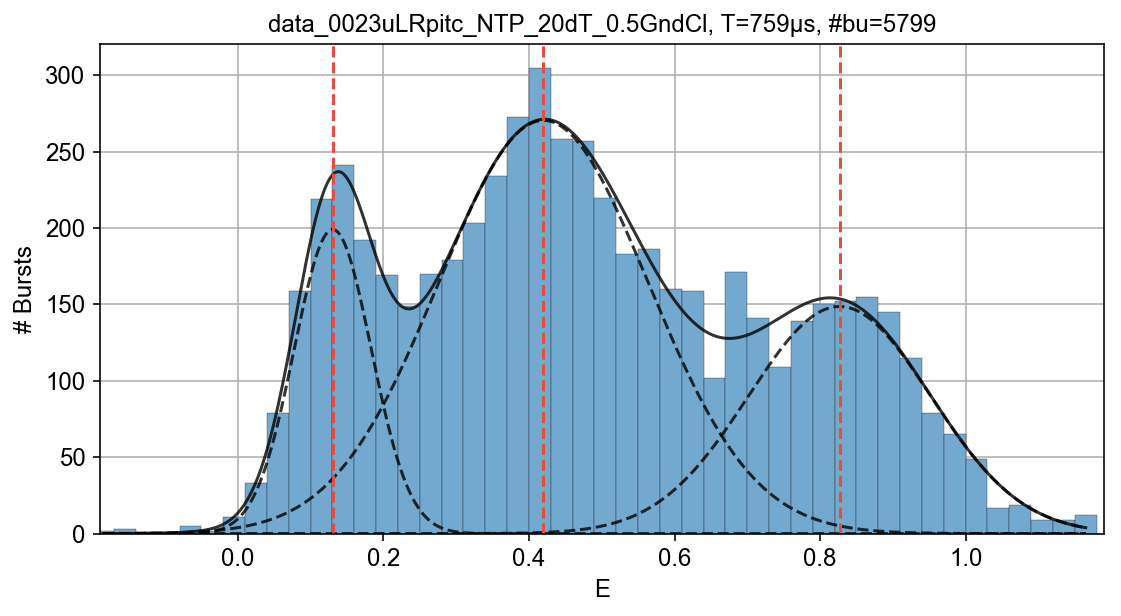

In [7]:
E_fitter = bext.bursts_fitter(ds, 'E', binwidth=0.03)
E_fitter.fit_histogram(model=model, pdf=False, method='nelder')
E_fitter.fit_histogram(model=model, pdf=False, method='leastsq')
dplot(ds, hist_fret, show_model=True, pdf=False);

In [8]:
# dplot(ds, hist_fret, show_model=True, pdf=False, figsize=(6, 4.5));
# plt.xlim(-0.1, 1.1)
# plt.savefig('fret_hist_fit.png', bbox_inches='tight', dpi=200, transparent=False)

The results are in `E_fitter`:

In [9]:
res = E_fitter.fit_res[0]
res.params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
p1_amplitude     26.43     0.01      inf    2.665     True     None     None
p1_center       0.1304     -0.1      0.3 0.003665     True     None     None
p1_fwhm         0.1247     -inf      inf 0.009604    False 2.3548200*p1_sigma     None
p1_height          199     -inf      inf     12.7    False 0.3989423*p1_amplitude/max(1.e-15, p1_sigma)     None
p1_sigma       0.05296     0.02      0.2 0.004079     True     None     None
p2_amplitude     97.73     0.01      inf    5.766     True     None     None
p2_center         0.42      0.3      0.7 0.006083     True     None     None
p2_fwhm         0.3394     -inf      inf  0.02357    False 2.3548200*p2_sigma     None
p2_height        270.5     -inf      inf    6.868    False 0.3989423*p2_amplitude/max(1.e-15, p2_sigma)     None
p2_sigma        0.1441     0.02     0.18  0.01001     True     None     None
p3_amplitude     46.61     0.01      inf      4.2     True 

To get a dictionary of values:

In [10]:
res.values

{'p1_amplitude': 26.425112546882755,
 'p1_center': 0.1304211780456301,
 'p1_fwhm': 0.12471768267083956,
 'p1_height': 199.04744887476406,
 'p1_sigma': 0.05296272439967367,
 'p2_amplitude': 97.725109792777,
 'p2_center': 0.419974100092639,
 'p2_fwhm': 0.3394332126358552,
 'p2_height': 270.47033272302514,
 'p2_sigma': 0.14414401637316449,
 'p3_amplitude': 46.61031803037159,
 'p3_center': 0.8267695396211263,
 'p3_fwhm': 0.2945718036320869,
 'p3_height': 148.6478716009145,
 'p3_sigma': 0.12509312967958777}

This is the startndard lmfit's fit report:

In [11]:
print(res.fit_report(min_correl=0.5))

[[Model]]
    ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(gaussian, prefix='p3_'))
[[Fit Statistics]]
    # function evals   = 156
    # data points      = 46
    # variables        = 9
    chi-square         = 7950.001
    reduced chi-square = 214.865
    Akaike info crit   = 255.005
    Bayesian info crit = 271.463
[[Variables]]
    p1_sigma:       0.05296272 +/- 0.004078 (7.70%) (init= 0.05)
    p1_center:      0.13042117 +/- 0.003665 (2.81%) (init= 0.1)
    p1_amplitude:   26.4251125 +/- 2.664757 (10.08%) (init= 1)
    p2_sigma:       0.14414401 +/- 0.010011 (6.95%) (init= 0.04)
    p2_center:      0.41997410 +/- 0.006082 (1.45%) (init= 0.4)
    p2_amplitude:   97.7251097 +/- 5.766403 (5.90%) (init= 1)
    p3_sigma:       0.12509312 +/- 0.010649 (8.51%) (init= 0.05)
    p3_center:      0.82676953 +/- 0.011870 (1.44%) (init= 0.85)
    p3_amplitude:   46.6103180 +/- 4.200092 (9.01%) (init= 1)
    p1_fwhm:        0.12471768 +/- 0.009604 (7.70%)  == '2.3548

The previous cell reports error ranges computed from the covariance matrix.
[More accurare confidence intervals](https://lmfit.github.io/lmfit-py/confidence.html) 
can be obtained with:

In [12]:
ci = res.conf_interval()
lmfit.report_ci(ci)

/Users/anto/miniconda3/envs/fretbursts-dev/lib/python3.6/site-packages/lmfit/confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 5 and prob(p2_sigma=0.19420068222167178) = 0.9928120659904571 < max(sigmas).
  warn(errmsg)


                 99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 p1_sigma    :  -0.01374  -0.00894  -0.00442   0.05296  +0.00456  +0.00953  +0.01531
 p1_center   :  -0.01193  -0.00771  -0.00382   0.13042  +0.00397  +0.00835  +0.01354
 p1_amplitude:  -9.30991  -6.10472  -3.00234  26.42511  +2.97612  +6.05976  +9.43949
 p2_sigma    :  -0.03326  -0.02232  -0.01138   0.14414  +0.01224  +0.02572      +inf
 p2_center   :  -0.02278  -0.01400  -0.00664   0.41997  +0.00641  +0.01298  +0.02009
 p2_amplitude: -22.75290 -14.16482  -6.83120  97.72511  +6.80352 +13.90510 +21.30745
 p3_sigma    :  -0.03201  -0.02169  -0.01125   0.12509  +0.01292  +0.02877  +0.04959
 p3_center   :  -0.05671  -0.03303  -0.01497   0.82677  +0.01330  +0.02587  +0.03840
 p3_amplitude: -13.74698  -9.15839  -4.65290  46.61032  +5.09443 +11.07792 +18.71141


# Tidy fit results

It is convenient to put the fit results in a DataFrame for further analysis.
A dataframe of fitted parameters is already in `E_fitter`:

In [13]:
E_fitter.params

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,26.4251,0.130421,0.0529627,97.7251,0.419974,0.144144,46.6103,0.82677,0.125093


With [`pybroom`](http://pybroom.readthedocs.io/) we can get a "tidy" DataFrame
with more complete fit results:

In [14]:
import pybroom as br

In [15]:
df = br.tidy(res)
df

,name,value,min,max,vary,expr,stderr,init_value
0,p1_amplitude,26.425113,0.010000,inf,True,None,2.664758,1.00
1,p1_center,0.130421,-0.100000,0.300000,True,None,0.003665,0.10
2,p1_fwhm,0.124718,-inf,inf,False,2.3548200*p1_sigma,0.009604,NaN
3,p1_height,199.047449,-inf,inf,False,"0.3989423*p1_amplitude/max(1.e-15, p1_sigma)",12.700874,NaN
4,p1_sigma,0.052963,0.020000,0.200000,True,None,0.004079,0.05
...,...,...,...,...,...,...,...,...
10,p3_amplitude,46.610318,0.010000,inf,True,None,4.200093,1.00
11,p3_center,0.826770,0.700000,1.100000,True,None,0.011871,0.85
12,p3_fwhm,0.294572,-inf,inf,False,2.3548200*p3_sigma,0.025078,NaN
13,p3_height,148.647872,-inf,inf,False,"0.3989423*p3_amplitude/max(1.e-15, p3_sigma)",6.991347,NaN


Now, for example, we can easily select parameters by name:

In [16]:
df.loc[df.name.str.contains('center')]

,name,value,min,max,vary,expr,stderr,init_value
1,p1_center,0.130421,-0.1,0.3,True,None,0.003665,0.10
6,p2_center,0.419974,0.3,0.7,True,None,0.006083,0.40
11,p3_center,0.826770,0.7,1.1,True,None,0.011871,0.85


In [17]:
df.loc[df.name.str.contains('sigma')]

,name,value,min,max,vary,expr,stderr,init_value
4,p1_sigma,0.052963,0.02,0.20,True,None,0.004079,0.05
9,p2_sigma,0.144144,0.02,0.18,True,None,0.010011,0.04
14,p3_sigma,0.125093,0.02,0.20,True,None,0.010650,0.05


---
**Executed:** Sat Nov 18 15:59:51 2017

**Duration:** 22 seconds.

**Autogenerated from:** [Example - FRET histogram fitting.ipynb](out/Example - FRET histogram fitting.ipynb)